# MVP 1: Baseline Object-Centric Event Stream Processing with Offline Discovery
## This notebook show functionalities of the first MVP of the project, which focuses on offline discovery of object-centric event streams.

Key changes:
1. `sources/` now accommodates .jsonocel files
2. `boevent.py` is a beamline object event that represents a single object-centric event in a stream.
3. `abstractevent.py` is an abstract base class for events, defining the interface for event objects as similariies between the two event types exists.

In [30]:
import importlib
import pybeamline  # replace with your module name
from pybeamline.mappers.sliding_window_to_ocel import log_to_ocel_operator
importlib.reload(pybeamline)
from pm4py import view_ocpn, view_ocdfg
from reactivex.operators import window_with_count
from reactivex import operators as ops
from pm4py.algo.discovery.ocel.ocdfg import algorithm as ocdfg_discovery
from pm4py.algo.discovery.ocel.ocpn import algorithm as ocpn_discovery
from pybeamline.mappers import sliding_window_to_log
from pybeamline.sources.ocel_json_log_source import ocel_json_log_source_from_file


In [31]:
# Load jsonocel file
log_source = ocel_json_log_source_from_file('../../tests/ocel.jsonocel')

# only print first 10 events
i = 0
def print_event(event):
    global i
    if i < 10:
        print(event)
        i += 1

log_source.pipe().subscribe(
    lambda x: print_event(x)
)


(reg_co1, Register Customer Order, 2023-05-22 11:54:42+00:00, [{'ocel:oid': 'co1', 'ocel:type': 'Customer Order'}])
(reg_co2, Register Customer Order, 2023-05-22 18:33:30+00:00, [{'ocel:oid': 'co2', 'ocel:type': 'Customer Order'}])
(create_td1, Create Transport Document, 2023-05-23 08:22:17+00:00, [{'ocel:oid': 'co2', 'ocel:type': 'Customer Order'}, {'ocel:oid': 'td1', 'ocel:type': 'Transport Document'}])
(book_vehs_td1, Book Vehicles, 2023-05-23 10:05:16+00:00, [{'ocel:oid': 'td1', 'ocel:type': 'Transport Document'}, {'ocel:oid': 'vh1', 'ocel:type': 'Vehicle'}, {'ocel:oid': 'vh4', 'ocel:type': 'Vehicle'}])
(reg_co3, Register Customer Order, 2023-05-23 12:14:57+00:00, [{'ocel:oid': 'co3', 'ocel:type': 'Customer Order'}])
(order_crs_td1, Order Empty Containers, 2023-05-23 13:22:08+00:00, [{'ocel:oid': 'td1', 'ocel:type': 'Transport Document'}, {'ocel:oid': 'cr1', 'ocel:type': 'Container'}, {'ocel:oid': 'cr5', 'ocel:type': 'Container'}, {'ocel:oid': 'cr2', 'ocel:type': 'Container'}, {'oc

In [32]:
# Sliding window of 1000 events
# only print summary of first 1000 events ocel event log
j = 0
def print_summary(ocel):
    global j
    if j < 1:
        print(ocel.get_summary())
        j = 1

# Pm4py OCEL object integration
log_source.pipe(
    window_with_count(1000),
    sliding_window_to_log(),
    log_to_ocel_operator()
).subscribe(lambda ocel: print_summary(ocel))

Object-Centric Event Log (number of events: 1000, number of objects: 467, number of activities: 13, number of object types: 7, events-objects relationships: 2013)
Activities occurrences: Counter({'Collect Goods': 310, 'Load Truck': 309, 'Pick Up Empty Container': 64, 'Drive to Terminal': 58, 'Weigh': 56, 'Place in Stock': 55, 'Register Customer Order': 27, 'Create Transport Document': 26, 'Book Vehicles': 26, 'Order Empty Containers': 23, 'Bring to Loading Bay': 22, 'Load to Vehicle': 20, 'Depart': 4})
Object types occurrences (number of objects): Counter({'Handling Unit': 310, 'Container': 84, 'Customer Order': 27, 'Transport Document': 26, 'Vehicle': 11, 'Truck': 6, 'Forklift': 3})
Unique activities per object type: Counter({'Container': 9, 'Forklift': 4, 'Transport Document': 4, 'Vehicle': 3, 'Customer Order': 2, 'Handling Unit': 2, 'Truck': 2})
Please use <THIS>.get_extended_table() to get a dataframe representation of the events related to the objects.


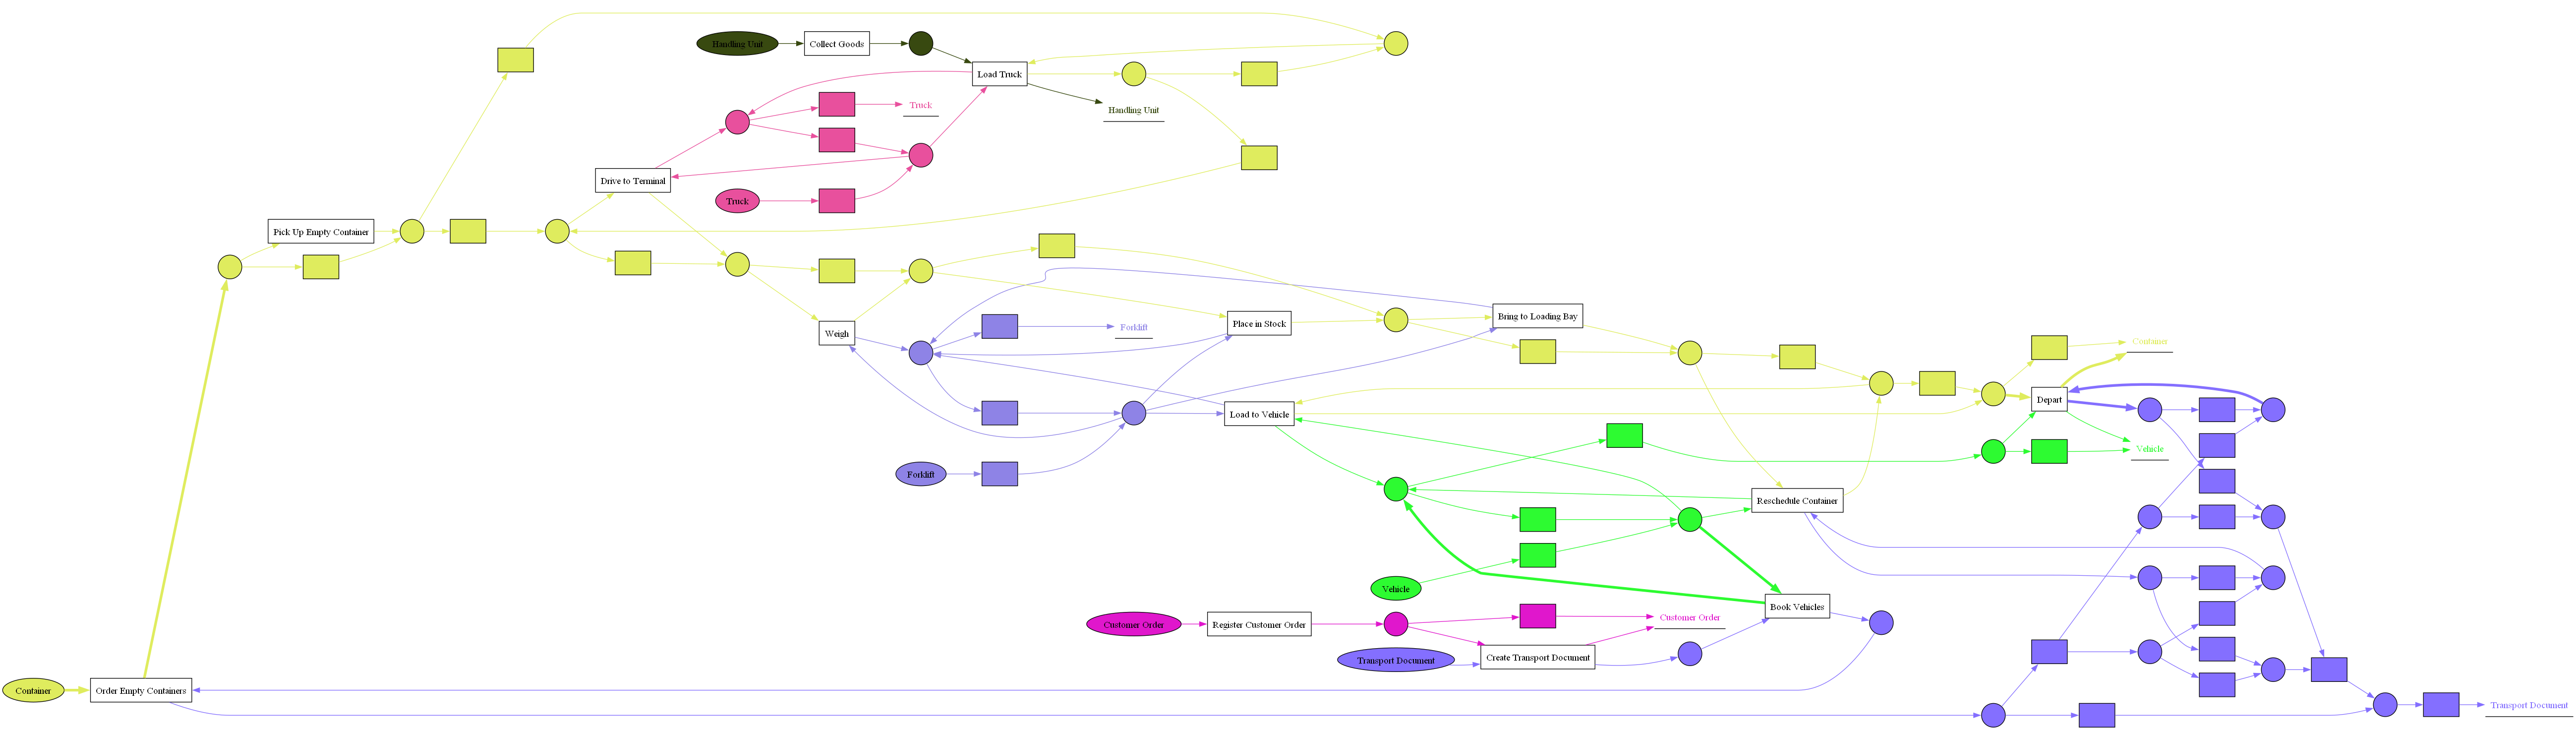

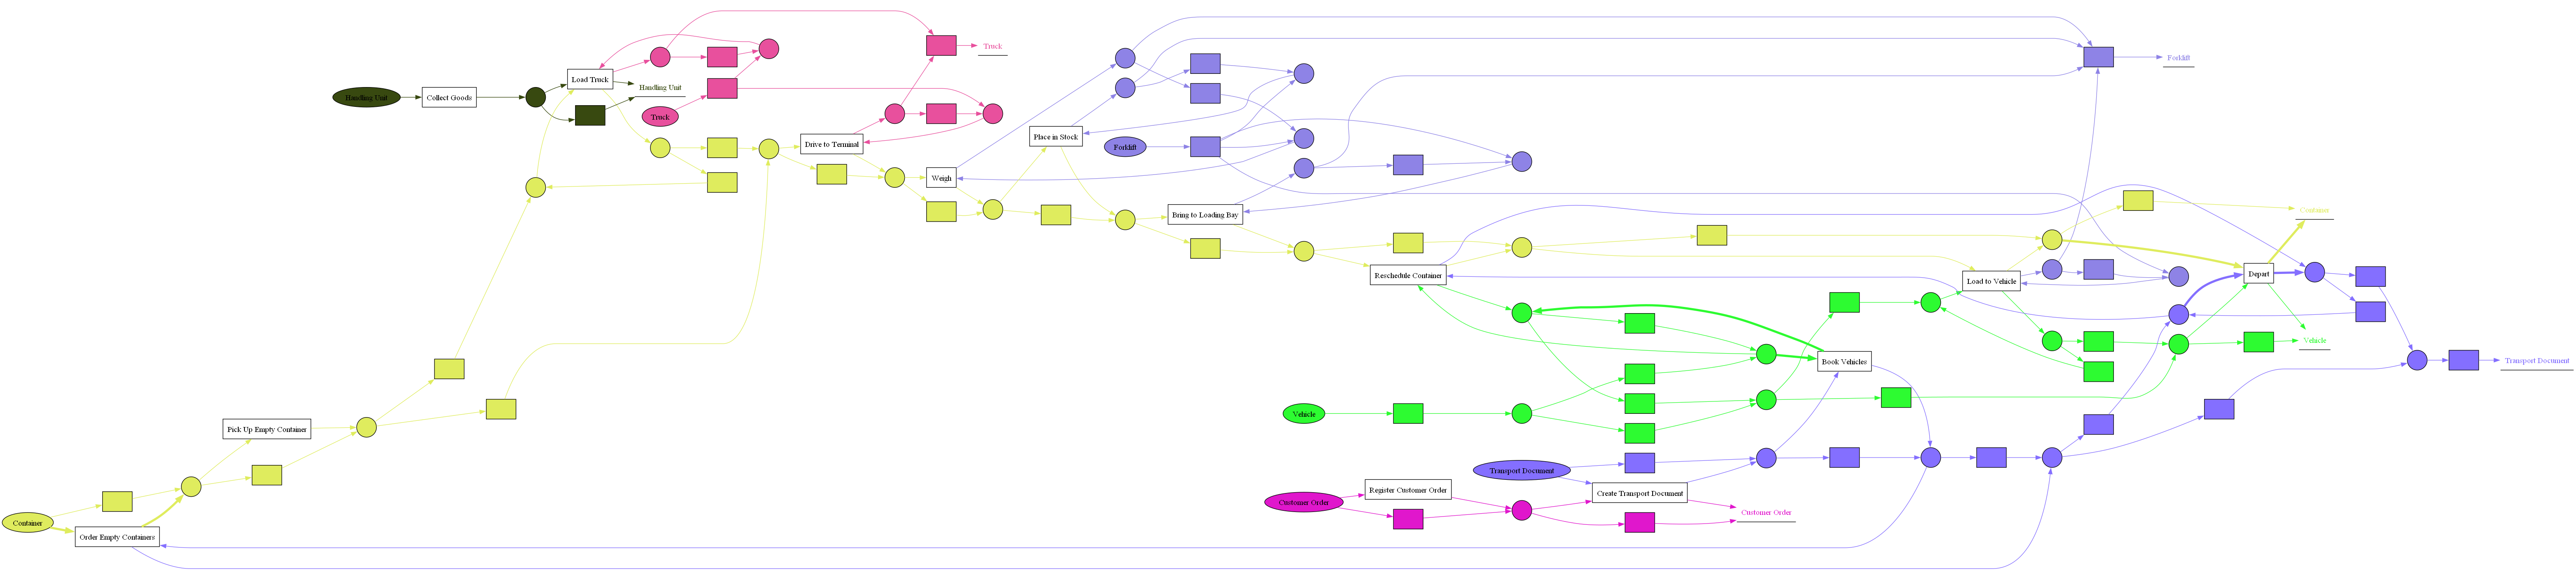

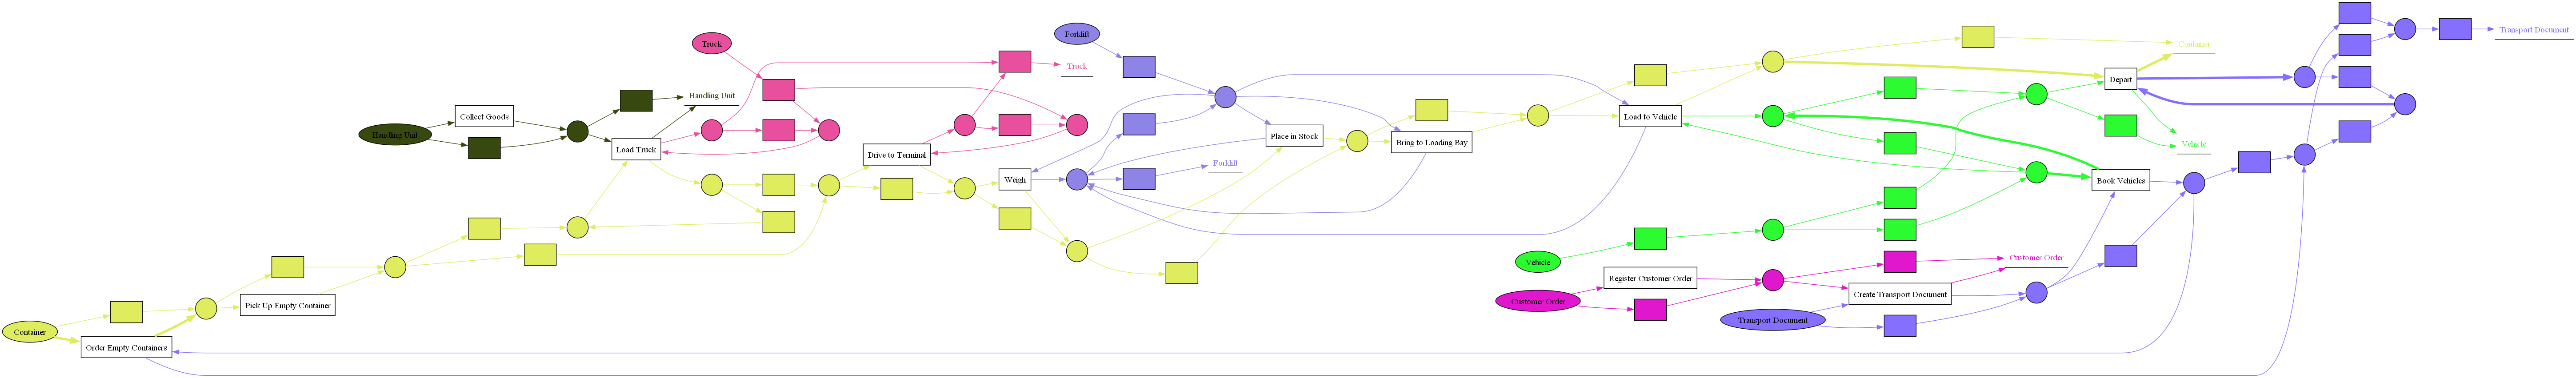

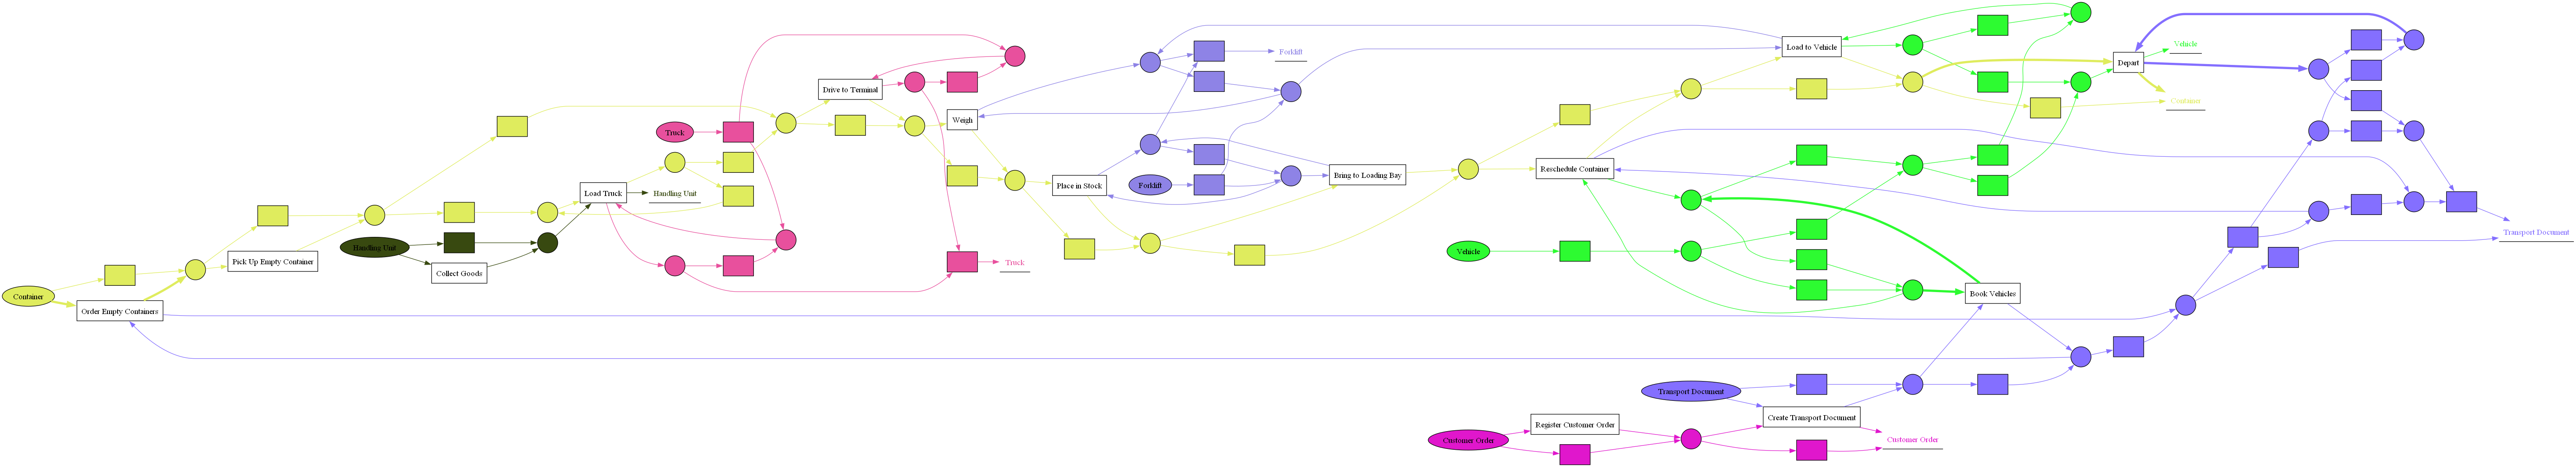

In [33]:
# Pm4py OCEL object centric petri net discovery
log_source.pipe(
    window_with_count(10000),
    sliding_window_to_log(),
    log_to_ocel_operator(),
    ops.map(lambda ocel: ocpn_discovery.apply(ocel))
).subscribe(lambda ocpn: view_ocpn(ocpn))

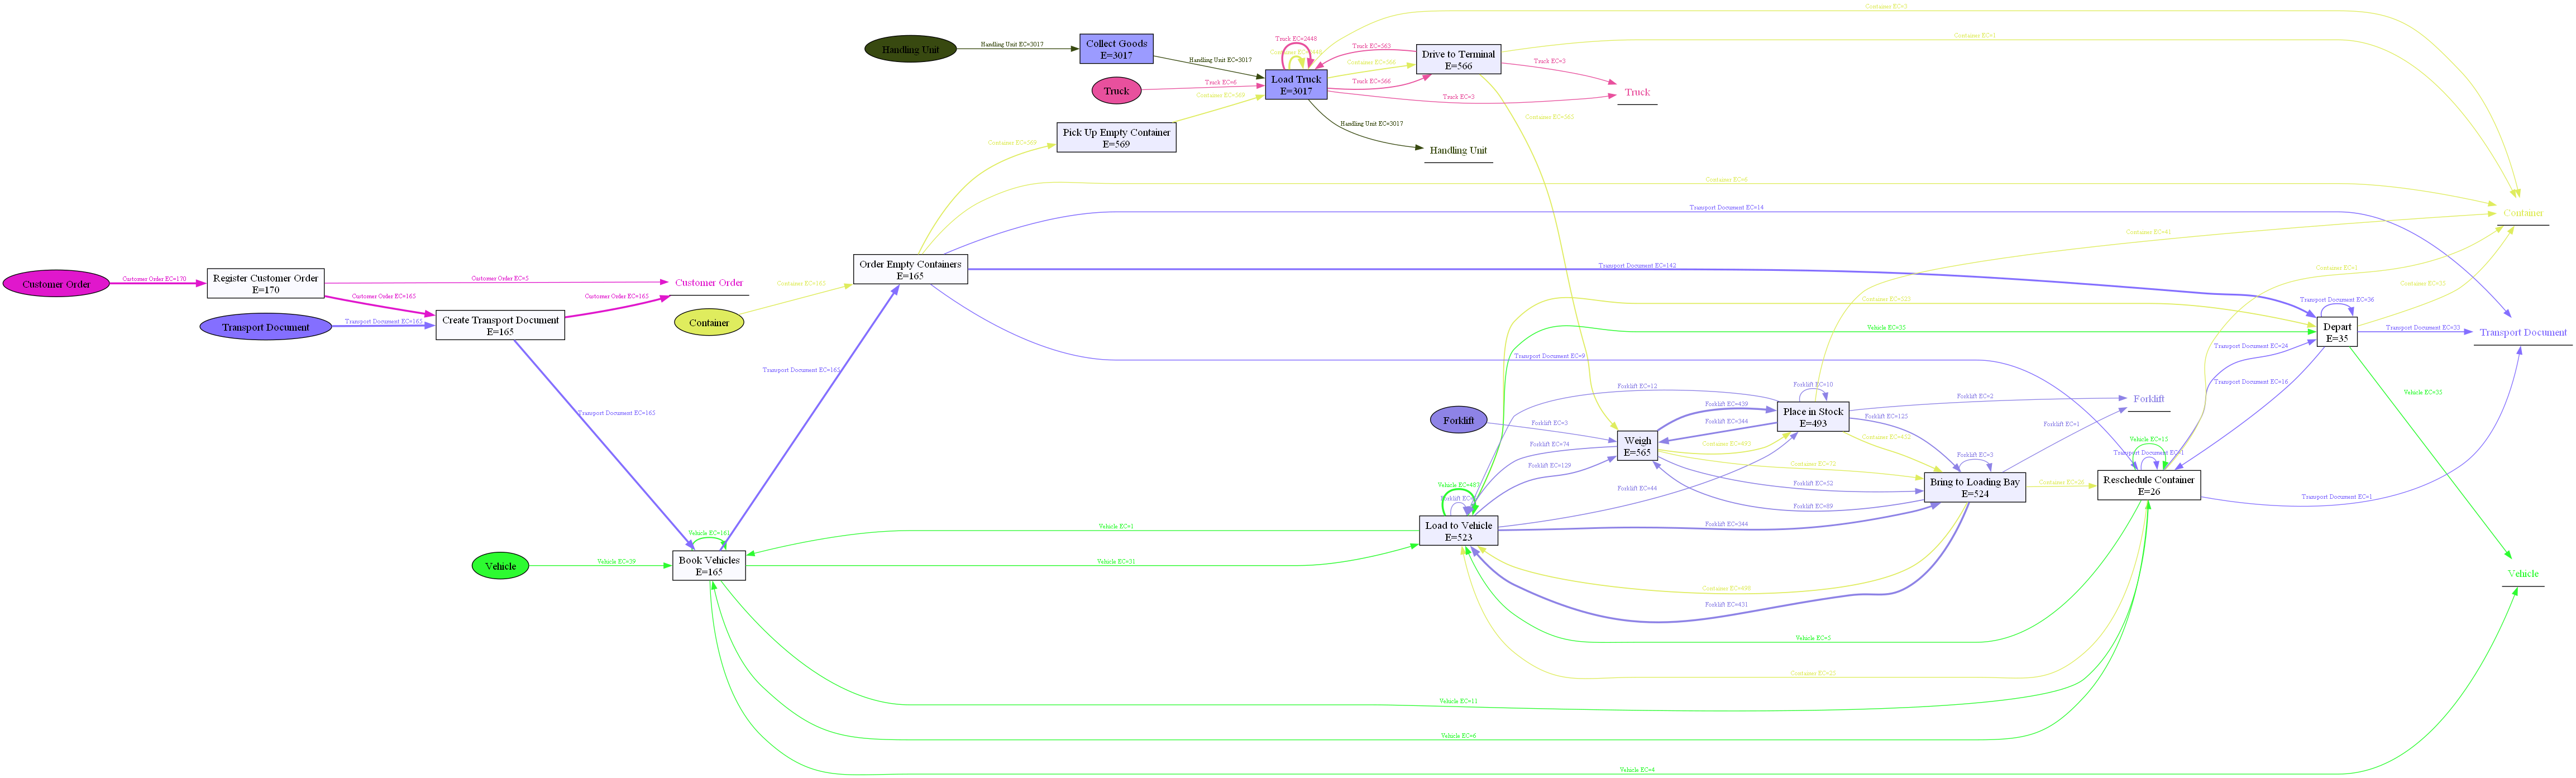

In [34]:


# Pm4py OCEL object centric direct follower graph discovery
h = 0
def view_one(ocdfg):
    global h
    if h < 1:
        view_ocdfg(ocdfg)
        h = h + 1

log_source.pipe(
    window_with_count(10000),
    sliding_window_to_log(),
    log_to_ocel_operator(),
    ops.map(lambda ocel: ocdfg_discovery.apply(ocel))
).subscribe(lambda ocdfg: view_one(ocdfg))

In [ ]:
import random

log_original =